In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
sample_df = pd.read_csv('../French_Comedies/Data/French_Comedies_Data_Sample.csv')

In [3]:
sample_df.head()

,index,title,last_name,first_name,date,translation/adaptation/contrastive,num_acts,url,num_present_characters,num_scenes_text,...,percentage_above_two_speakers,av_percentage_non_speakers,sigma_iarkho,number_scenes_with_discontinuous_change_characters,percentage_scenes_with_discontinuous_change_characters,total_utterances,num_verse_lines,dialogue_vivacity,five_year_intervals,decades
0,F_51,Les Apparences trompeuses,Boisrobert,François Le Métel de,1655,0,5,NaN,12,45,...,43.18,6.288,1.002,7,15.909,NaN,NaN,NaN,1655,1660
1,F_54,Le Marquis ridicule,Scarron,Paul,1656,0,5,http://www.theatre-classique.fr/pages/document...,10,24,...,43.24,22.387,1.692,3,8.108,637.0,1654.0,0.385,1660,1660
2,F_212,La Belle-mère ou les Dangers d'un second mariage,Vigée,Louis-Jean-Baptiste-Étienne,1788,0,5,NaN,10,42,...,16.67,4.167,0.950,5,11.905,NaN,NaN,NaN,1790,1790
3,F_206,L'École des pères,Pieyre,Alexandre,1787,0,5,NaN,9,63,...,13.64,10.606,0.785,2,3.030,NaN,NaN,NaN,1790,1790
4,F_266,Le Faux bonhomme,Duval,Alexandre,1821,0,5,NaN,8,42,...,26.67,6.481,1.134,0,0.000,NaN,NaN,NaN,1825,1830


In [4]:
sample_df.columns

Index(['index', 'title', 'last_name', 'first_name', 'date',
       'translation/adaptation/contrastive', 'num_acts', 'url',
       'num_present_characters', 'num_scenes_text', 'num_scenes_iarkho',
       'speech_distribution', 'percentage_monologues', 'percentage_duologues',
       'percentage_non_duologues', 'percentage_above_two_speakers',
       'av_percentage_non_speakers', 'sigma_iarkho',
       'number_scenes_with_discontinuous_change_characters',
       'percentage_scenes_with_discontinuous_change_characters',
       'total_utterances', 'num_verse_lines', 'dialogue_vivacity',
       'five_year_intervals', 'decades'],
      dtype='object')

In [5]:
sample_df.shape

(29, 25)

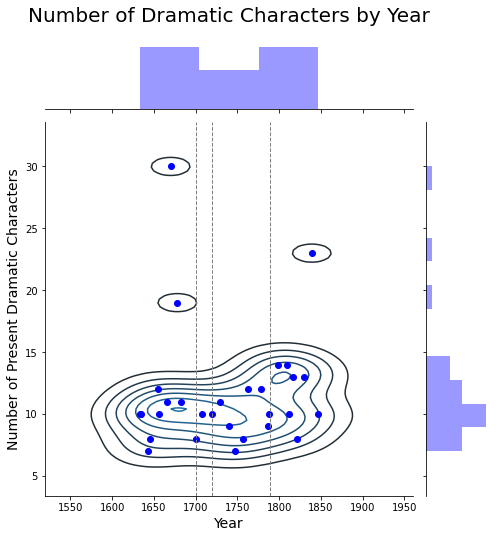

In [6]:
sns.jointplot('date', 'num_present_characters',
                   data=sample_df, color="b", height=7).plot_joint(sns.kdeplot, zorder=0, n_levels=7)
plt.title('Number of Dramatic Characters by Year', fontsize=20, pad=100)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Present Dramatic Characters', fontsize=14)
period_one = plt.axvline(1700, color='grey',linestyle='dashed', linewidth=1)
period_one = plt.axvline(1720, color='grey',linestyle='dashed', linewidth=1)
period_two = plt.axvline(1789, color='grey',linestyle='dashed', linewidth=1)
plt.show()

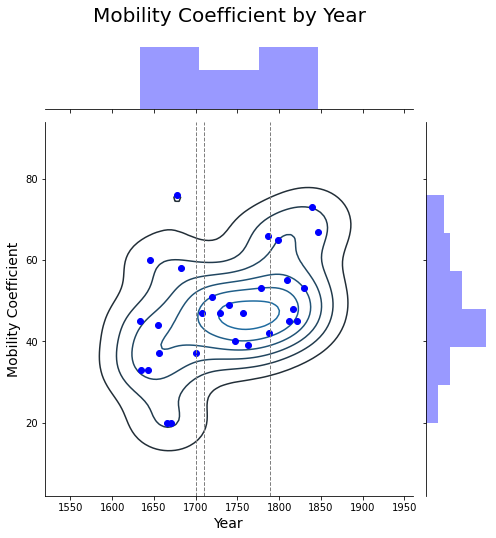

In [7]:
sns.jointplot('date', 'num_scenes_iarkho',
                   data=sample_df, color="b", height=7).plot_joint(sns.kdeplot, zorder=0, n_levels=7)
plt.title('Mobility Coefficient by Year', fontsize=20, pad=100)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mobility Coefficient', fontsize=14)
period_one = plt.axvline(1700, color='grey',linestyle='dashed', linewidth=1)
period_one = plt.axvline(1710, color='grey',linestyle='dashed', linewidth=1)
period_two = plt.axvline(1789, color='grey',linestyle='dashed', linewidth=1)
plt.show()

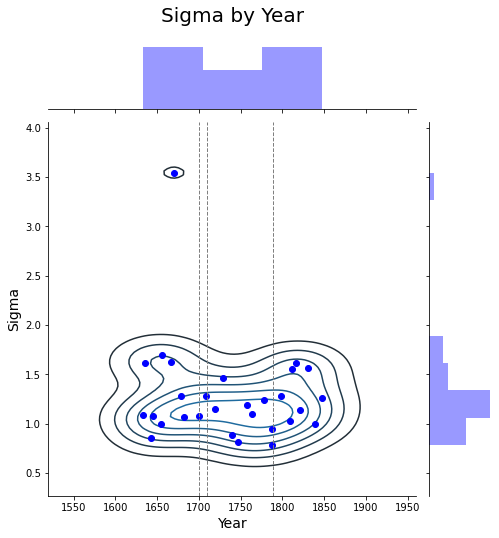

In [8]:
sns.jointplot('date', 'sigma_iarkho',
                   data=sample_df, color="b", height=7).plot_joint(sns.kdeplot, zorder=0, n_levels=7)
plt.title('Sigma by Year', fontsize=20, pad=100)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Sigma', fontsize=14)
period_one = plt.axvline(1700, color='grey',linestyle='dashed', linewidth=1)
period_one = plt.axvline(1710, color='grey',linestyle='dashed', linewidth=1)
period_two = plt.axvline(1789, color='grey',linestyle='dashed', linewidth=1)
plt.show()

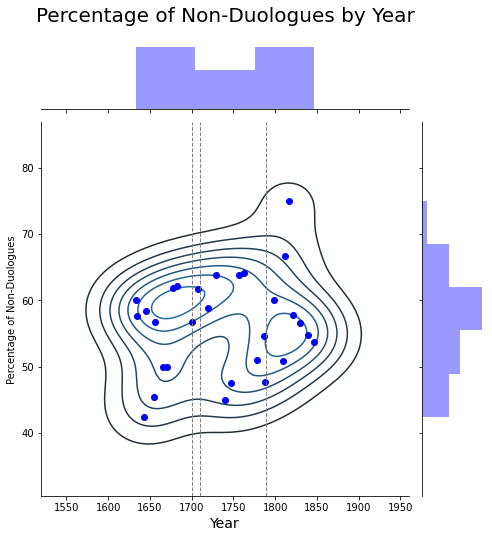

In [9]:
sns.jointplot('date', 'percentage_non_duologues',
                   data=sample_df, color="b", height=7).plot_joint(sns.kdeplot, zorder=0, n_levels=7)
plt.title('Percentage of Non-Duologues by Year', fontsize=20, pad=100)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage of Non-Duologues')
period_one = plt.axvline(1700, color='grey',linestyle='dashed', linewidth=1)
period_one = plt.axvline(1710, color='grey',linestyle='dashed', linewidth=1)
period_two = plt.axvline(1789, color='grey',linestyle='dashed', linewidth=1)
plt.show()